In [2]:
import serial


In [122]:
class MBP:
    def __init__(self, COM_port):
        self.ser = serial.Serial('COM1', 9600, parity=serial.PARITY_NONE, stopbits = 1,
                    xonxoff = 0, timeout = 0.5, bytesize = 8)
        
    def read(self):
        stop = b'\rD >'
        ret = b''
        while True:
            b = self.ser.read(1)
            if b == b'\r':
                self.ser.read(3)
                break
            else:
                ret += b
        return ret.decode()

    def command(self, command):
        self.ser.write(str.encode(command+'\r'))
        return self.read()
    
    def GetModel(self):
        return self.command("GETMODEL")
    
    def LaserState(self, laser = 0):
        return self.command(f"LASERSTATE {laser}")
    
    def Power(self, point = 3):
        return self.command(f"POWER {point}")
    
    def GetLDEnable(self):
        return self.command('getLDenable')
    
    def GetPower(self, point = 0):
        return self.command(f'GETPOWER {point}')
    
    def GetMode(self):
        return self.command('GETMODE')
    
    def GetState(self):
        return self.command('GETSTATE')
    
    def GetOut(self):
        return self.command('GETOUT')
    
    def GetLaserState(self):
        return self.command('GETLASERSTATE')

    def GetLaserStateSym(self, value = 0):
        """
        Returns the strings corresponding to the laserstate integer returns.
        Note that param value does not correspond to the integer returned by
        GetLaserState, need to loop through value 0 to 17 to get all
        corresponding codes.
        E.g. 0 -> OFF
             6 -> KEYLOCK
             7 -> INTERLOCK
        """
        return self.command(f'GETLASERSTATESYM {value}')

    def GetPowerEnable(self):
        return self.command('GETPOWERENABLE')
    
    def GetFault(self):
        """
        Get faults, returns 5 bits
        1   SHG temperature
        2   TEC temperature
        3   Laser diode current
        4   Watchdog timeout
        5   Case temperature
        """
        return self.command('GETFLT')

    def GetAlarm(self):
        """
        Get alarms, returns 5 bits
        1   SHG temperature
        2   TEC temperature
        3   Pump bias
        4   Loss of output
        5   Case temperature
        """
        return self.command('GETALR')
    
    def SetEnv(self, env = 0):
        return self.command(f'SETENV {env}')
    
    def EnterTestEnvironment(self):
        return self.command('testeoa')+self.read()+self.read()
    
    def SetSHGTemperature(self, temperature = 50.7):
        return self.command(f'SETTECSETPT 4 {temperature}')

    def GetSHGSetpoint(self):
        return self.command('GETTECSETPT 4')
    
    def SetLDEnable(self, on = 0):
        """
        Enabling the MBP amplifier
        """
        return self.command(f'setLDenable {on}')

    def GetLDCurrent(self, ld = 0):
        """
        Returns the LD {ld} current setpoint
        """
        return self.command(f'GETLDCURRENT {ld}')

    def SetLDCurrent(self, ld = 3, current = 1000):
        """
        Set the LD {ld} current setpoint
        """
        return self.command(f'SETLDCURRENT {ld} {current}')

    def LDCurrent(self, ld = 3):
        """
        Returns the actual LD {ld} current
        """
        return self.command(f'LDCURRENT {ld}')

    def PowerEnable(self, enable = 0):
        """
        Set the amplifier to ACC or APC mode
        0   ACC
        1   APC
        """
        return self.command(f'POWERENABLE {enable}')
    
    def GetSHGTemperature(self):
        return self.command('TECTEMP 4')

In [98]:
mbp = MBP('COM1')
for f in [func for func in dir(mbp) if (callable(getattr(mbp, func)) & ('__' not in func) & (func not in ['command', 'read']))]:
    print(f'{f:20}:', getattr(mbp, f)())
mbp.ser.close()

EnterTestEnvironment: TEST ENVIRONMENTy knowledgeable personnel should use test commands.sure to observe all pertinent safety precautions.
GetAlarm            : 0 0 0 0 0 0
GetFault            : 0 0 0 0 0
GetLDCurrent        : RS232.C 1 UNKNOWN_COMMAND
GetLDEnable         : 0
GetLaserState       : 0
GetLaserStateSym    : 0 OFF
GetMode             : 1
GetModel            : 2RU-VYFL-P-1000-543.5-SF-FRCPC
GetOut              : 0 0 0 1
GetPower            : 600
GetPowerEnable      : 1
GetSHGSetpoint      : 50.7
GetState            : 1
LDCurrent           : 0
LaserState          : CMD.C 11 INACTIVE_LD#_(A.1)
Power               : 9.1609
PowerEnable         : 
SetEnv              : 
SetLDCurrent        : RS232.C 1 UNKNOWN_COMMAND
SetSHGTemperature   : RS232.C 7 CAN_ONLY_BE_USED_FOR_TESTS
setLDEnable         : 


## SHG Temperature Scan for power optimization

In [174]:
import numpy as np
import time
power_in = []
power_out = []
temp_SHG = []
ld3_current = []

temp = np.arange(50.5, 50.95, 0.03)

mbp = MBP('COM1')
mbp.EnterTestEnvironment()
mbp.SetLDEnable(1)
time.sleep(20)

for idt, t in enumerate(temp):
    mbp.SetSHGTemperature(t)
    print(f'{mbp.GetSHGSetpoint()}: {idt+1}/{len(temp)}')
    time.sleep(15)
    pintmp =[]
    pouttmp = []
    shgtemptmp = []
    ld3tmp = []
    for _ in range(10):
        pintmp.append(mbp.Power(3))
        pouttmp.append(mbp.Power(0))
        shgtemptmp.append(mbp.GetSHGTemperature())
        ld3tmp.append(mbp.LDCurrent(3))
        time.sleep(0.1)
    power_in.append(pintmp)
    power_out.append(pouttmp)
    temp_SHG.append(shgtemptmp)
    ld3_current.append(ld3tmp)
    time.sleep(1)

mbp.SetLDEnable(0)
mbp.ser.close()

50.5: 1/16
50.53: 2/16
50.56: 3/16
50.59: 4/16
50.62: 5/16
50.65: 6/16
50.68: 7/16
50.71: 8/16
50.74: 9/16
50.77: 10/16
50.8: 11/16
50.83: 12/16
50.86: 13/16
50.89: 14/16
50.92: 15/16
50.95: 16/16


In [377]:
np.array(power_in, float).flatten()

array([8.59746, 8.5919 , 8.5919 , 8.5919 , 8.59746, 8.60324, 8.60324,
       8.60324, 8.59746, 8.5919 , 8.72837, 8.72259, 8.74549, 8.73415,
       8.75682, 8.73415, 8.75104, 8.7626 , 8.7626 , 8.7626 , 8.9902 ,
       9.00154, 8.99576, 9.01287, 9.02421, 9.02421, 9.03554, 9.04132,
       9.0471 , 9.0471 , 9.1609 , 9.1609 , 9.1609 , 9.15512, 9.1609 ,
       9.1609 , 9.1609 , 9.1609 , 9.1609 , 9.1609 , 8.9902 , 8.9902 ,
       8.9902 , 8.98442, 8.97864, 8.96731, 8.96175, 8.95019, 8.9333 ,
       8.9333 , 8.6488 , 8.6488 , 8.6488 , 8.6488 , 8.6488 , 8.6488 ,
       8.6488 , 8.6488 , 8.6488 , 8.6488 , 8.47232, 8.46099, 8.44387,
       8.44965, 8.45521, 8.43809, 8.43809, 8.43809, 8.4212 , 8.43809,
       8.37564, 8.3643 , 8.36986, 8.38697, 8.37564, 8.38119, 8.38119,
       8.38697, 8.38697, 8.36986, 8.4781 , 8.4781 , 8.4781 , 8.4781 ,
       8.48366, 8.4781 , 8.49499, 8.4781 , 8.49499, 8.51789, 8.7057 ,
       8.7057 , 8.71126, 8.72837, 8.72259, 8.75104, 8.75682, 8.75682,
       8.7626 , 8.76

In [395]:
data_type = np.dtype([('SHG temperature setpoint', np.float), ('seed power', np.float), ('output power', np.float), ('SHG temperature measured', np.float), ('LD3 current', np.float)])

with h5py.File('mbp_communications_measurements.hdf5', 'w') as f:
    data = np.array([np.repeat(temp, 10), np.array(power_in).flatten(), np.array(power_out).flatten(), np.array(temp_SHG).flatten(), np.array(ld3_current).flatten()]).T
    data = np.array([tuple(d) for d in data], dtype = data_type)
    dset = f.create_dataset('SHG_temperature_scan', data = data)
    dset.attrs['description'] = "Measurement of MBP Communications 2RU-VYFA-SF Series amplifier output power as a function of SHG temperature"
    dset.attrs['seed'] = 'NKT Photonics Koheras Basic'
    dset.attrs['frequency [GHz]'] = 275844.950
    dset.attrs['units'] = "{'SHG temperature setpoint': 'C', 'seed power': 'mW', 'output power': 'mW', 'SHG temperature measured': 'C', 'LD3 current': 'mA'}"

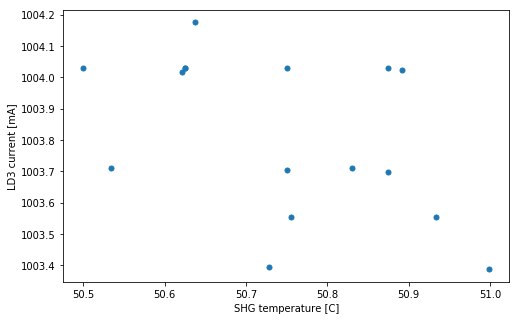

In [175]:
%matplotlib inline
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize = (8,5))
ax.plot(np.array(temp_SHG).astype(float).mean(axis = 1), np.array(ld3_current).astype(float).mean(axis = 1), '.', ms = 10)
ax.set_xlabel('SHG temperature [C]')
ax.set_ylabel('LD3 current [mA]');

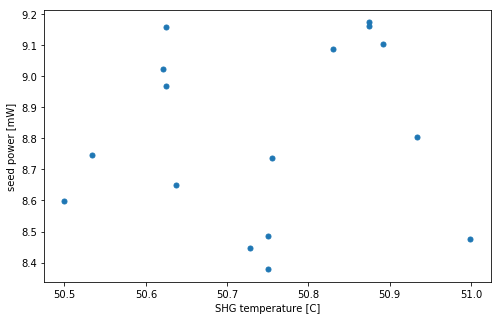

In [199]:
%matplotlib inline
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize = (8,5))
ax.plot(np.array(temp_SHG).astype(float).mean(axis = 1), np.array(power_in).astype(float).mean(axis = 1), '.', ms = 10)
ax.set_xlabel('SHG temperature [C]')
ax.set_ylabel('seed power [mW]');

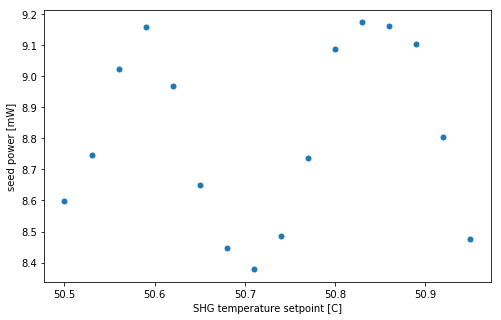

In [207]:
%matplotlib inline
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize = (8,5))
ax.plot(temp, np.array(power_in).astype(float).mean(axis = 1), '.', ms = 10)
ax.set_xlabel('SHG temperature setpoint [C]')
ax.set_ylabel('seed power [mW]');

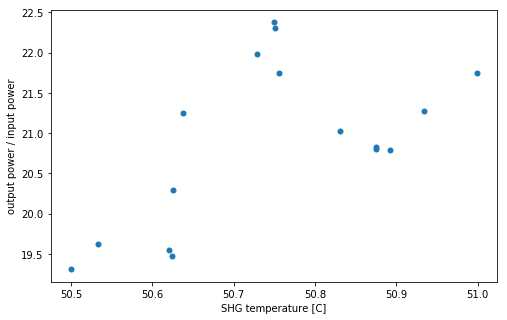

In [200]:
%matplotlib inline
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize = (8,5))
ax.plot(np.array(temp_SHG).astype(float).mean(axis = 1), (np.array(power_out).astype(float)/np.array(power_in).astype(float)).mean(axis = 1), '.', ms = 10)
ax.set_xlabel('SHG temperature [C]')
ax.set_ylabel('output power / input power');

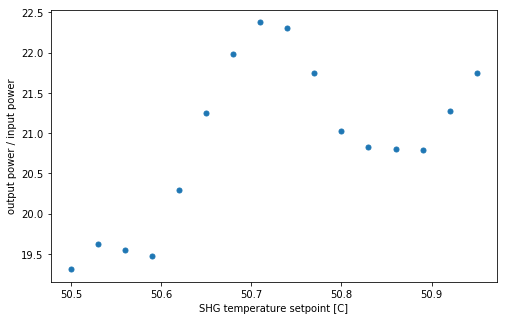

In [204]:
%matplotlib inline
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize = (8,5))
ax.plot(np.array(temp).astype(float), (np.array(power_out).astype(float)/np.array(power_in).astype(float)).mean(axis = 1), '.', ms = 10)
ax.set_xlabel('SHG temperature setpoint [C]')
ax.set_ylabel('output power / input power');

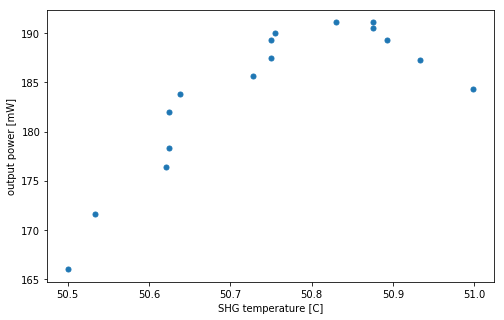

In [201]:
%matplotlib inline
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize = (8,5))
ax.plot(np.array(temp_SHG).astype(float).mean(axis = 1), np.array(power_out).astype(float).mean(axis = 1), '.', ms = 10)
ax.set_xlabel('SHG temperature [C]')
ax.set_ylabel('output power [mW]');

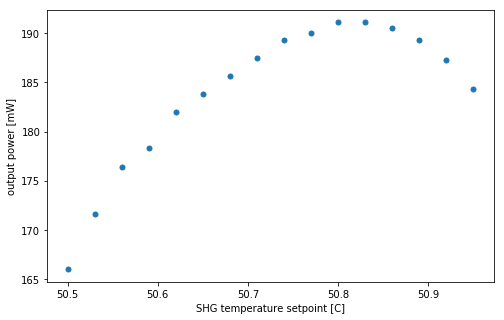

In [205]:
%matplotlib inline
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize = (8,5))
ax.plot(temp, np.array(power_out).astype(float).mean(axis = 1), '.', ms = 10)
ax.set_xlabel('SHG temperature setpoint [C]')
ax.set_ylabel('output power [mW]');

In [208]:
mbp = MBP('COM1')
mbp.EnterTestEnvironment()
mbp.SetSHGTemperature(50.7)
mbp.ser.close()

## Input power monitoring

In [227]:
# import numpy as np
# import time

# total_time = 60*30
# dt = 0.1

# mbp = MBP('COM1')


# power_in_mon = np.empty(int(total_time/dt))
# time_measured = np.empty(int(total_time/dt))

# try:
#     for _ in range(int(total_time/dt)):
#         power_in_mon[_] = float(mbp.Power(3))
#         time_measured[_] = time.time()
#         time.sleep(dt)
# except KeyboardInterrupt:
#     mbp.ser.close()

# mbp.ser.close()

In [396]:
import h5py

data_type = np.dtype([('time', np.float), ('power', np.float)])

with h5py.File('mbp_communications_measurements.hdf5', 'a') as f:
    data = np.array([time_measured, power_in_mon]).T
    data = np.array([tuple(d) for d in data], dtype = data_type)
    dset = f.create_dataset('seed_power_monitoring', data = data)
    dset.attrs['description'] = "Measurement of MBP Communications 2RU-VYFA-SF Series amplifier input seed power from NKT Photonics Koheras Basik"
    dset.attrs['seed'] = 'NKT Photonics Koheras Basic'
    dset.attrs['frequency [GHz]'] = 275844.950
    dset.attrs['units'] = "{'time': 's', 'power': 'mW'}"

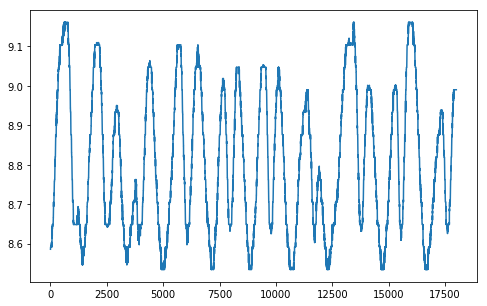

In [228]:
fig, ax = plt.subplots(figsize = (8,5))
ax.plot(np.array(power_in_mon, dtype = float))